## K Nearest Neighbours: Work best with datasets having <2000 datapoints(smaller datasets)

1. Determine the value of k using elbow method or hyperparameter tuning with Grid Search CV.
2. Plot the eblow curve, finalise the value of k
3. Build the model
4. Evaluate using respective metrics




### Business Usecase: Build a model that can prescribe Drug to the patient on basis of their gender, medical history.

## Data Gathering

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv(r'https://raw.githubusercontent.com/sindhura-nk/Datasets/refs/heads/main/drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## Perform basic quality checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
df.shape

(200, 6)

In [5]:
df.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [6]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

## Separate X and Y features
Y: Drug

In [8]:
X = df.drop(columns='Drug')
Y =df[['Drug']]

In [9]:
X.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [10]:
Y.head()

,Drug
0,DrugY
1,drugC
2,drugC
3,drugX
4,DrugY


## Data Preprocessing and Data cleaning

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

In [12]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore',sparse_output=False)
)

pre = ColumnTransformer([
    ('cat',cat_pipe,cat),
    ('con',num_pipe,con)
]).set_output(transform='pandas')

In [13]:
X_pre = pre.fit_transform(X)
X_pre.head()

,cat__Sex_F,cat__Sex_M,cat__BP_HIGH,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_HIGH,cat__Cholesterol_NORMAL,con__Age,con__Na_to_K
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.291591,1.286522
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.162699,-0.415145
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.162699,-0.828558
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.988614,-1.149963
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.011034,0.271794


## Split the data into training and testing

In [14]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X_pre,Y,train_size=0.75,random_state=21)
print(f'xtrain:{xtrain.shape}, xtest:{xtest.shape},ytrain:{ytrain.shape}, ytest:{ytest.shape}')

xtrain:(150, 9), xtest:(50, 9),ytrain:(150, 1), ytest:(50, 1)


## KNN Model Building

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(xtrain,ytrain)

,n_neighbors,10
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [17]:
model.score(xtrain,ytrain)

0.9133333333333333

In [18]:
model.score(xtest,ytest)

0.8

## Evaluation of model

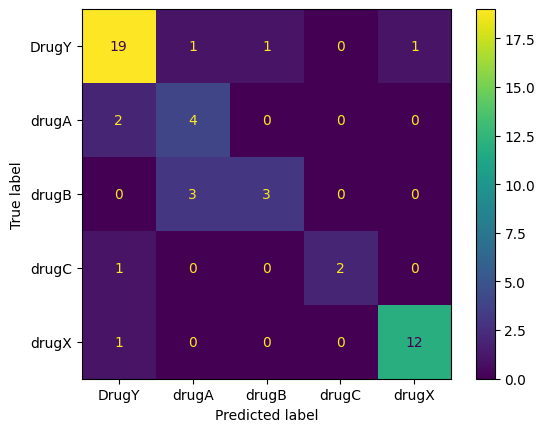

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
ConfusionMatrixDisplay.from_estimator(model,xtest,ytest)

In [20]:
print(classification_report(ytest,y_pred=model.predict(xtest)))

              precision    recall  f1-score   support

       DrugY       0.83      0.86      0.84        22
       drugA       0.50      0.67      0.57         6
       drugB       0.75      0.50      0.60         6
       drugC       1.00      0.67      0.80         3
       drugX       0.92      0.92      0.92        13

    accuracy                           0.80        50
   macro avg       0.80      0.72      0.75        50
weighted avg       0.81      0.80      0.80        50



## Hyperparameter tuning: GridsearchCV/RandomisedSearch CV

In [21]:
params = {
    'n_neighbors':[2,3,4,5,6,7,8,9,10]
}

In [22]:
from sklearn.model_selection import GridSearchCV
base_model = KNeighborsClassifier()
gscv = GridSearchCV(estimator=base_model,param_grid=params,cv=3,scoring='f1_macro')
gscv.fit(xtrain,ytrain)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [2, 3, ...]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,7


In [23]:
gscv.best_params_

{'n_neighbors': 7}

In [24]:
best_knn = gscv.best_estimator_
best_knn.score(xtrain,ytrain)

0.8933333333333333

In [25]:
best_knn.score(xtest,ytest)

0.76

## We can consider model for final predictions

## Out of sample data: future data being provided by client. Client wants you to generate the predictions and return the results in a csv file

In [30]:
path2 = r'https://raw.githubusercontent.com/sindhura-nk/Datasets/refs/heads/main/DrugTest.csv'
xnew = pd.read_csv(path2)
xnew.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,22.0,F,HIGH,NORMAL,22.818
1,15.0,M,HIGH,NORMAL,17.206
2,67.0,M,NORMAL,NORMAL,9.514
3,68.0,M,NaN,HIGH,11.009
4,70.0,F,NORMAL,HIGH,NaN


In [31]:
xnew_pre = pre.transform(xnew)
# Using finalsed model to predict the final drugs to be prescribed
Drug_predicted = best_knn.predict(xnew_pre)
# Adding the predictions to Xnew data 
xnew['Drug Predicted'] = Drug_predicted
# save the xnew results into a csv file
xnew.to_csv('DrugResults.csv',index=False)